Importação de bibliotecas necessárias:
- sklearn para o agrupamento (AgglomerativeClustering)
- scipy para a distância par a par (scipy.spatial.distance.pdist) e transformar vetor em matriz quadrada
- preciso de numpy, pandas e matplotlib para algumas coisas

In [27]:
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

Leitura do arquivo em tsv, ou seja, separados por \t.
Após isso, removo a classe (coluna 0) por se tratar de um notebook sobre agurpamento (não supervisionado)

In [33]:
data = pd.read_csv('ECG5000_TRAIN.tsv', delimiter='\t', header=None)
data = data.drop(0, axis = 1)

In [34]:
data.shape

(500, 140)

O método pdist recebe uma tabela atributo-valor (nesse caso, de observações de cada exemplo/série) e retorna uma matriz quadrada com as asi distâncias entre toodos os pares. Porém, a matriz é implícita. O retorno é um vetor contendo todos os valores, mas é preciso transformar em matriz. Neste notebook eu faço isso de forma explícita (por didática e para não ficar repetindo contas), mas o AgglomerativeClustering poderia fazer por mim (no caso da Euclidiana).

In [35]:
m_dist = pdist(data)
print(m_dist.shape)

(124750,)


In [36]:
m_dist = squareform(m_dist)
print(m_dist.shape)

(500, 500)


Antes de fazer o agrupamento, eu vou tentar representar os meus dados em duas dimensões. Primeiro, usando MDS.

In [37]:
from sklearn.manifold import MDS

embedding = MDS(n_components=2, dissimilarity='precomputed')
X_transformed = embedding.fit_transform(m_dist)
print(X_transformed.shape)

(500, 2)


Text(0.5, 1.0, 'MDS com euclidiana')

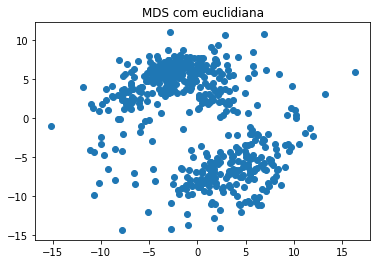

In [38]:
plt.scatter(X_transformed[:, 0], X_transformed[:, 1])
plt.title('MDS com euclidiana')

Testando um single-linkage. Para ver como ficou, sigo plotando um dendrograma.

In [39]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs): # método encontrado em https://stackoverflow.com/questions/29127013/plot-dendrogram-using-sklearn-agglomerativeclustering

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [40]:
clustering = AgglomerativeClustering(linkage='single', affinity='precomputed').fit(m_dist)

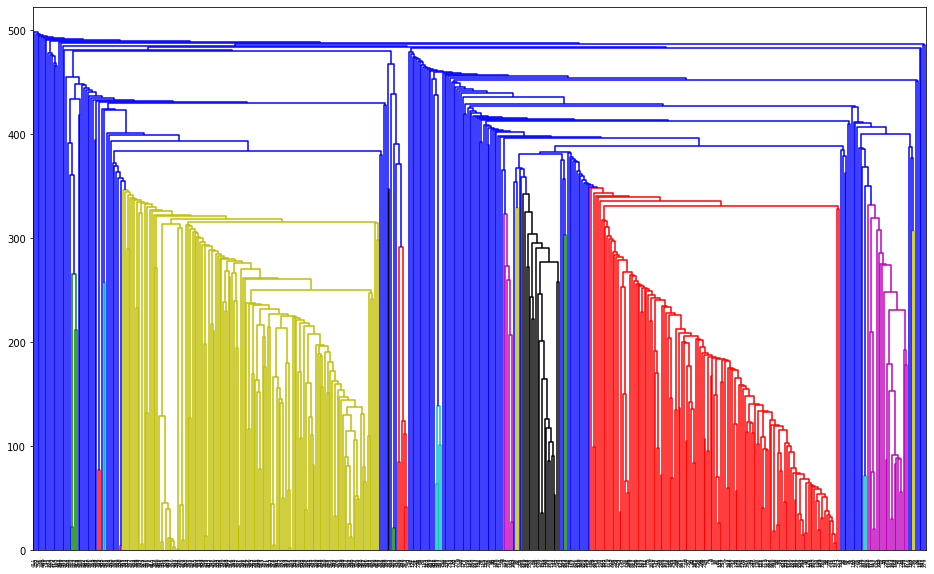

In [41]:
plt.figure(figsize=(16, 10))
plot_dendrogram(clustering)
plt.show()

Vou repetir o experimento com complete-linkage.

In [42]:
clustering = AgglomerativeClustering(linkage='complete', affinity='precomputed').fit(m_dist)

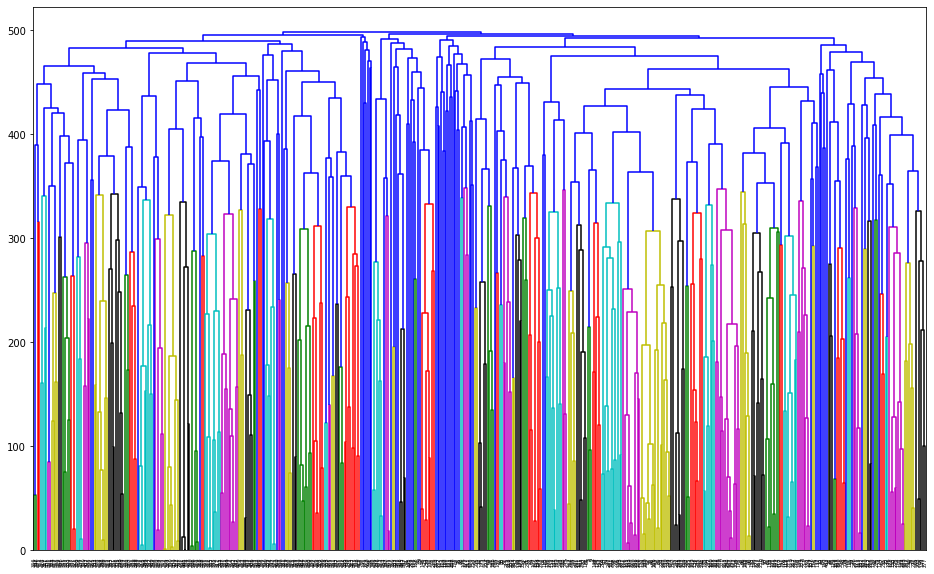

In [43]:
plt.figure(figsize=(16, 10))
plot_dendrogram(clustering)
plt.show()

Vou plotar o MDS novamente, mas comas cores relativas ao agrupamento (se n_clusters=2). Ou seja, eu estou propondo um corte no dendrograma para ficar com dois grupos.

In [44]:
clustering = AgglomerativeClustering(linkage='single', 
                                     n_clusters=2,
                                     affinity='precomputed').fit(m_dist)

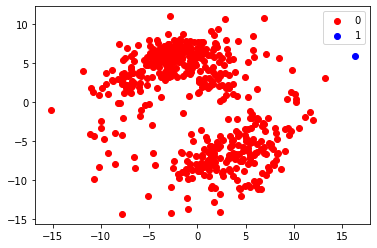

In [48]:
cdict = {0: 'red', 1: 'blue'} # dicionário de cores para o plot

fig, ax = plt.subplots()
for g in np.unique(clustering.labels_):
    ix = np.where(clustering.labels_ == g)
    ax.scatter(X_transformed[ix, 0], X_transformed[ix, 1], 
               c = cdict[g], 
               label = g)
ax.legend()
plt.show()

O single linkage ficou muito ruim, então vamos no complete.

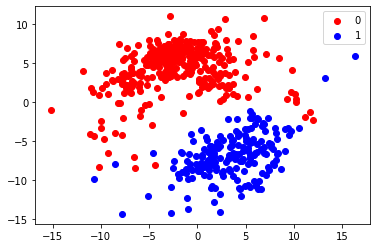

In [49]:
clustering = AgglomerativeClustering(linkage='complete', 
                                     n_clusters=2,
                                     affinity='precomputed').fit(m_dist)

cdict = {0: 'red', 1: 'blue'} # dicionário de cores para o plot

fig, ax = plt.subplots()
for g in np.unique(clustering.labels_):
    ix = np.where(clustering.labels_ == g)
    ax.scatter(X_transformed[ix, 0], X_transformed[ix, 1], 
               c = cdict[g], 
               label = g)
ax.legend()
plt.show()

Vamos verificar a silhueta deste agrupamento.

In [50]:
from sklearn.metrics import silhouette_score

silhouette_score(m_dist, clustering.labels_, metric='precomputed')

0.4521227688075296